# IMPORT LIBRARIES

In [65]:
import os
import glob
import numpy as np
from scipy.stats import linregress
from sklearn.metrics import r2_score
import pandas as pd # pandas allows to do a lot of basic data manipulation such as loading csv data files
import matplotlib.pyplot as plt # matplotlib is a basic ploting library of Python
import matplotlib.dates as mdates  # Import matplotlib date handling
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec
import seaborn as sns

# LOAD DATA

Isotope data

In [66]:
iso_data = pd.read_csv('../data/processed/SOURCES_dataset.csv') # chamber flux and isotopic data
iso_data['date'] = pd.to_datetime(iso_data['date']) # convert date to datetime
# Filter rows with diff_n2o_ppb above threshold and drop missing values
threshold = 30
iso_data = iso_data[iso_data['diff_n2o_ppb'] > threshold].dropna()

# Compute mean d18O of water
d18O_soil_water = iso_data['d18O_water'].mean()
print("average d18O-H2O is", d18O_soil_water)

iso_data

average d18O-H2O is -9.241605815533335


,date,chamber,SP,d15N,d18O,diff_n2o_ppb,flux_nmol,d18O_water
2,2023-03-01,1,18.213941,-29.436341,17.273349,4779.619396,14.025316,-8.335530
3,2023-03-03,1,5.489893,-23.678948,18.781280,4496.289482,12.993894,-10.864481
4,2023-03-06,1,-0.199149,-27.943262,20.818652,1843.023597,5.272311,-9.530335
12,2023-03-06,2,2.289056,-26.599452,33.210678,47.108978,0.134764,-9.893990
18,2023-03-01,3,16.211476,-25.740525,18.961443,5296.327715,15.541545,-8.741820
19,2023-03-03,3,-0.130329,-21.078954,19.088668,2643.390218,7.639173,-10.314688
20,2023-03-06,3,-4.179072,-22.605849,19.538232,389.707596,1.114831,-10.056549
21,2023-03-17,3,-2.373949,-13.489280,28.669395,303.798338,0.848329,-10.256006
26,2023-03-01,4,-1.378079,-25.445839,22.037094,926.302519,2.718142,-8.840135
27,2023-03-03,4,-3.755073,-27.393237,24.454761,127.826654,0.369408,-10.226242


FRAME summary output

In [67]:
results = pd.read_csv("../data/processed/FRAME/OE2_results.csv") # summary of FRAME simulations
input = pd.read_csv("../data/processed/FRAME/N2O_samples_FRAME.csv") # FRAME input data to extract info on chamber number and date 
df_summary = pd.merge(results, input, on='group') # merge summary of FRAME output with FRAME samples input data
df_summary['chamber'] = pd.to_numeric(df_summary['label'].str[1]) # get the chamber number from the label
df_summary['date'] = pd.to_datetime(df_summary['label'].str[3:], format='%Y-%m-%d') # get the date from the label and convert to datetime
df_summary = pd.merge(df_summary, iso_data, on=['date', 'chamber'], how='left') # merge original isotope data based on the date and the chamber
df_summary['reduced_fraction'] = 1 - df_summary['mean_r']
df_summary

EmptyDataError: No columns to parse from file

Complete FRAME output

In [ ]:
# Define the folder path
folder_path = "../data/processed/FRAME/"

# Get all files starting with 'group_' and ending with '.csv'
files = glob.glob(os.path.join(folder_path, "group_*.csv"))

# Initialize an empty list to store dataframes
dfs = []

# Loop through files and read them
for file in files:
    # Extract the group number from the filename
    filename = os.path.basename(file)
    group_number = filename.split("_")[1].split(".")[0]

    # Read the CSV file
    df = pd.read_csv(file)

    # Pool together (Ni, bD) for nitrification and (bD, nD) for denitrification
    df['nitrification'] = df['Ni'] + df['fD']
    df['denitrification'] = df['bD'] + df['nD']

    # Add the group column
    df['group'] = group_number

    # Append to the list
    dfs.append(df)

# Merge all dataframes
full_output = pd.concat(dfs, ignore_index=True)

# merge FRAME output with FRAME samples input data
full_output['group'] = full_output['group'].astype(int)  # Convert to int
df_full = pd.merge(full_output, input, on='group') # merge results and input
df_full['chamber'] = pd.to_numeric(df_full['label'].str[1]) # get the chamber number from the label
df_full['date'] = pd.to_datetime(df_full['label'].str[3:], format='%Y-%m-%d') # get the date from the label and convert to datetime
iso_data['date'] = pd.to_datetime(iso_data['date']) # convert date to datetime
df_full = pd.merge(df_full, iso_data, on=['date', 'chamber'], how='left') # merge with the original isotope data based on the date and the chamber
df_full

,r,Ni,bD,fD,nD,SP_x,d18O_x,d15N_x,Unnamed: 8,nitrification,...,d15N_y,stdev(d15N),chamber,date,SP,d15N,d18O,diff_n2o_ppb,flux_nmol,d18O_water
0,0.814011,0.158317,0.389948,0.220078,0.231657,12.098128,21.278066,-38.826023,NaN,0.378395,...,-29.436341,0,1,2023-03-01,18.213941,-29.436341,17.273349,4779.619396,14.025316,-8.335530
1,0.459152,0.230080,0.448764,0.058364,0.262793,12.293845,26.265763,-35.774178,NaN,0.288444,...,-29.436341,0,1,2023-03-01,18.213941,-29.436341,17.273349,4779.619396,14.025316,-8.335530
2,0.903804,0.032379,0.455481,0.315920,0.196221,10.327124,20.943549,-35.907663,NaN,0.348298,...,-29.436341,0,1,2023-03-01,18.213941,-29.436341,17.273349,4779.619396,14.025316,-8.335530
3,0.383637,0.325830,0.455594,0.084431,0.134145,18.352891,31.524575,-33.668550,NaN,0.410260,...,-29.436341,0,1,2023-03-01,18.213941,-29.436341,17.273349,4779.619396,14.025316,-8.335530
4,0.607259,0.229124,0.234886,0.188675,0.347314,14.894429,25.322009,-42.131967,NaN,0.417799,...,-29.436341,0,1,2023-03-01,18.213941,-29.436341,17.273349,4779.619396,14.025316,-8.335530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7241,0.381989,0.007868,0.606539,0.068876,0.316717,5.261660,26.346921,-29.591933,NaN,0.076744,...,-25.445839,0,4,2023-03-01,-1.378079,-25.445839,22.037094,926.302519,2.718142,-8.840135
7242,0.622945,0.088758,0.466190,0.023732,0.421320,3.375765,18.128218,-38.223745,NaN,0.112490,...,-25.445839,0,4,2023-03-01,-1.378079,-25.445839,22.037094,926.302519,2.718142,-8.840135
7243,0.428354,0.004617,0.357217,0.097671,0.540495,4.601542,24.445921,-37.771056,NaN,0.102289,...,-25.445839,0,4,2023-03-01,-1.378079,-25.445839,22.037094,926.302519,2.718142,-8.840135
7244,0.818665,0.038764,0.614628,0.134119,0.212489,4.639650,17.291464,-33.504392,NaN,0.172884,...,-25.445839,0,4,2023-03-01,-1.378079,-25.445839,22.037094,926.302519,2.718142,-8.840135


# PLOTS

## DUAL ISOTOPE MAPS  
Endmembers and reduction according to Yu et al. (2020) adjusted for d18O of water for the d18O vs. SP plot (except for Ni)

In [ ]:
# Define process boxes for d18O-SP and d15N-SP diagrams
process_boxes = {
    'd18O': {
        'Ni': dict(x=23.5, y=35, xmin=20.5, xmax=26.5, ymin=32, ymax=38.7),
        'bD': dict(
            x=19.2 + d18O_soil_water, y=-1.9,
            xmin=16.7 + d18O_soil_water, xmax=23.3 + d18O_soil_water,
            ymin=-7.5, ymax=3.7
        ),
        'fD': dict(
            x=47.2 + d18O_soil_water, y=33.5,
            xmin=42 + d18O_soil_water, xmax=55.1 + d18O_soil_water,
            ymin=27.2, ymax=39.9
        ),
        'nD': dict(
            x=((12.4 + 19.4) / 2) + d18O_soil_water, y=-5.9,
            xmin=12.4 + d18O_soil_water, xmax=19.4 + d18O_soil_water,
            ymin=-13.6, ymax=1.9
        )
    },
    'd15N': {
        'Ni': dict(x=-57, y=35, xmin=-64, xmax=-47, ymin=32, ymax=38.7),
        'bD': dict(x=-25.9, y=-1.9, xmin=-52.8, xmax=2.3, ymin=-7.5, ymax=3.7),
        'fD': dict(x=-38, y=33.5, xmin=-46, xmax=-31, ymin=27.2, ymax=39.9),
        'nD': dict(x=-56.9, y=-5.9, xmin=-60.7, xmax=-53.1, ymin=-13.6, ymax=1.9)
    }
}

# Slope parameters for SP vs. d18O and d15N plots
slopes = {
    'SP_d18O': {
        'reduction': 0.45,
        'mixing_bD_Ni': 6.1,
        'mixing_bD_fD': 1.3
    },
    'SP_d15N': {
        'reduction': 0.96,
        'mixing_bD_Ni': -1.2,
        'mixing_bD_fD': -2.7
    }
}

# Box labels offsets
label_offsets = {
    'SP_d18O': {
        'Ni': {'x': 0, 'y': +1},
        'bD': {'x': +2, 'y': -2},
        'fD': {'x':  0, 'y': +1},
        'nD': {'x': -1, 'y':  0},
    },
    'SP_d15N': {
        'Ni': {'x': -1, 'y': +1},
        'bD': {'x': +2, 'y': -3},
        'fD': {'x':  0, 'y': +1},
        'nD': {'x': -1, 'y':  0},
    }
}

For the sake of the plot we need the chamber as a category

In [ ]:
iso_data['chamber'] = iso_data['chamber'].astype('category')

### d18O vs SP

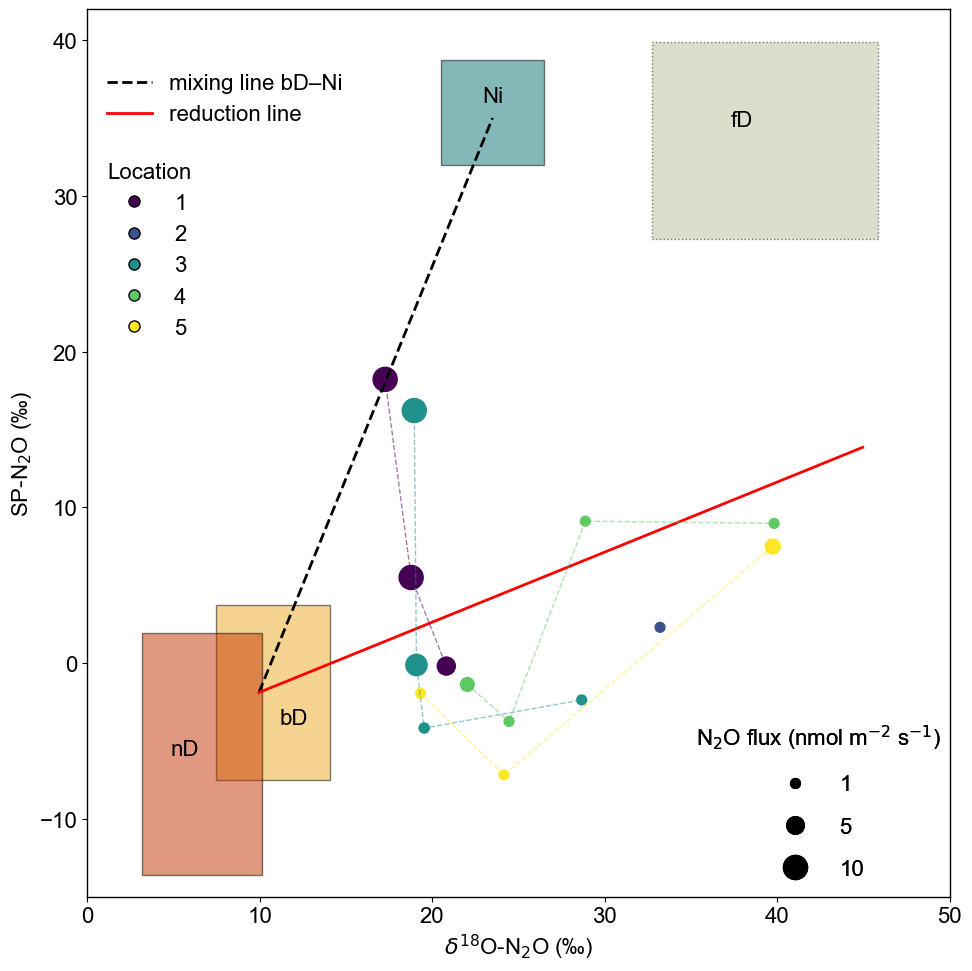

In [ ]:
def plot_d18O_SP(ax):
    # Unpack box data
    d18O_boxes = process_boxes['d18O']
    colors = {'Ni': '#0A7373', 'bD': '#EDAA25', 'fD': '#B7BF99', 'nD': '#C43302'}

    # Draw shaded boxes
    for label, box in d18O_boxes.items():
        rect = plt.Rectangle((box['xmin'], box['ymin']),
                             box['xmax'] - box['xmin'],
                             box['ymax'] - box['ymin'],
                             facecolor=colors[label], alpha=0.5,
                             linestyle='dotted' if label == 'fD' else 'solid',
                             edgecolor='black')
        ax.add_patch(rect)
        # Add the box labels
        offset = label_offsets['SP_d18O'].get(label, {'x': 0, 'y': 0})
        ax.text(box['x'] + offset['x'], box['y'] + offset['y'],
                label, ha='center')

    # Reduction and mixing lines
    x_bD, y_bD = d18O_boxes['bD']['x'], d18O_boxes['bD']['y']
    x_Ni, y_Ni = d18O_boxes['Ni']['x'], d18O_boxes['Ni']['y']
    x_fD, y_fD = d18O_boxes['fD']['x'], d18O_boxes['fD']['y']
    x_end = x_bD + 35
    y_end = y_bD + 35 * slopes['SP_d18O']['reduction']

    ax.plot([x_bD, x_Ni], [y_bD, y_Ni], 'k--', lw=2, label="mixing line bD–Ni")
 #   ax.plot([x_bD, x_fD], [y_bD, y_fD], 'k--', lw=2, label="mixing line bD–fD")
    ax.plot([x_bD, x_end], [y_bD, y_end], 'r-', lw=2, label="reduction line")

    # Rescale flux to point size
    min_size, max_size = 50, 300
    flux = iso_data['flux_nmol']
    sizes = np.interp(flux, (1, 10), (min_size, max_size))

    # Scatter
    scatter = ax.scatter(iso_data['d18O'], iso_data['SP'],
                         c=iso_data['chamber'].cat.codes,
                         s=sizes, cmap='viridis', edgecolor='face')

    # Annotate date
    # for _, row in iso_data.iterrows():
    #     ax.annotate(row['date'].strftime('%d').lstrip("0"),
    #                 (row['d18O'], row['SP']),
    #                 xytext=(8, -8), textcoords='offset points', fontsize=8)

    # Chamber lines
    chambers = iso_data['chamber'].cat.categories
    colors_chamber = plt.cm.viridis(np.linspace(0, 1, len(chambers)))
    for i, chamber in enumerate(chambers):
        subset = iso_data[iso_data['chamber'] == chamber]
        ax.plot(subset['d18O'], subset['SP'], linestyle='dashed',
                linewidth=1, alpha=0.5, color=colors_chamber[i])

    # --- Reference lines legend
    reference_lines = [
        Line2D([0], [0], color='black', linestyle='--', linewidth=2, label='mixing line bD–Ni'),
    #    Line2D([0], [0], color='black', linestyle='--', linewidth=2, label='mixing line bD–fD'),
        Line2D([0], [0], color='red', linestyle='-', linewidth=2, label='reduction line')
    ]

    legend1 = ax.legend(handles=reference_lines,
                        loc="upper left",
                        bbox_to_anchor=(0, 0.95),
                        frameon=False)  # no title
    ax.add_artist(legend1)

    # --- Color legend
    chambers = iso_data['chamber'].cat.categories
    colors_chamber = plt.cm.viridis(np.linspace(0, 1, len(chambers)))
    legend_colors = [Line2D([0], [0], marker='o', color='none',
                            label=ch,
                            markerfacecolor=colors_chamber[i],
                            markersize=8)
                    for i, ch in enumerate(chambers)]

    legend2 = ax.legend(handles=legend_colors,
                        title="Location", 
                        loc="upper left",
                        bbox_to_anchor=(0, 0.85),
                        frameon=False)
    ax.add_artist(legend2)

    # --- Size legend
    flux_vals = [1, 5, 10]
    sizes_legend = np.interp(flux_vals, (1, 10), (min_size, max_size))
    legend_sizes = [
        Line2D([0], [0], marker='o', linestyle='None',
            markerfacecolor='black', markeredgecolor='black',
            markersize=np.sqrt(s), label=f"{f}")
        for f, s in zip(flux_vals, sizes_legend)
    ]

    legend3 = ax.legend(
        handles=legend_sizes,
        title="N$_{2}$O flux (nmol m$^{-2}$ s$^{-1}$)",
        loc="lower right",
        bbox_to_anchor=(1, 0.01),
        frameon=False,
        handletextpad=1,     # space between symbol and label
        borderaxespad=0,     # padding between the legend and the axes (plot) border
        labelspacing=1       # vertical spacing
    )
    ax.add_artist(legend3)

    # Axis formatting
    ax.set_xlabel(r'$\delta^{18}$O-N$_2$O (‰)')
    ax.set_ylabel(r'SP-N$_2$O (‰)')
    ax.set_xlim(0, 50)
    ax.set_ylim(-15, 42)
    ax.grid(False)
    ax.set_facecolor('white')
    ax.spines[:].set_linewidth(1)
    ax.tick_params(axis='both', which='major')
    return ax

# Plot
fig, ax = plt.subplots(figsize=(10, 10))  # Create one axis
plot_d18O_SP(ax)                          # Draw your plot on it
plt.tight_layout()
plt.savefig('../figures/N2O_dual_isotope_plot_d18O-SP.png', dpi=300)
plt.show()

### d15N vs SP

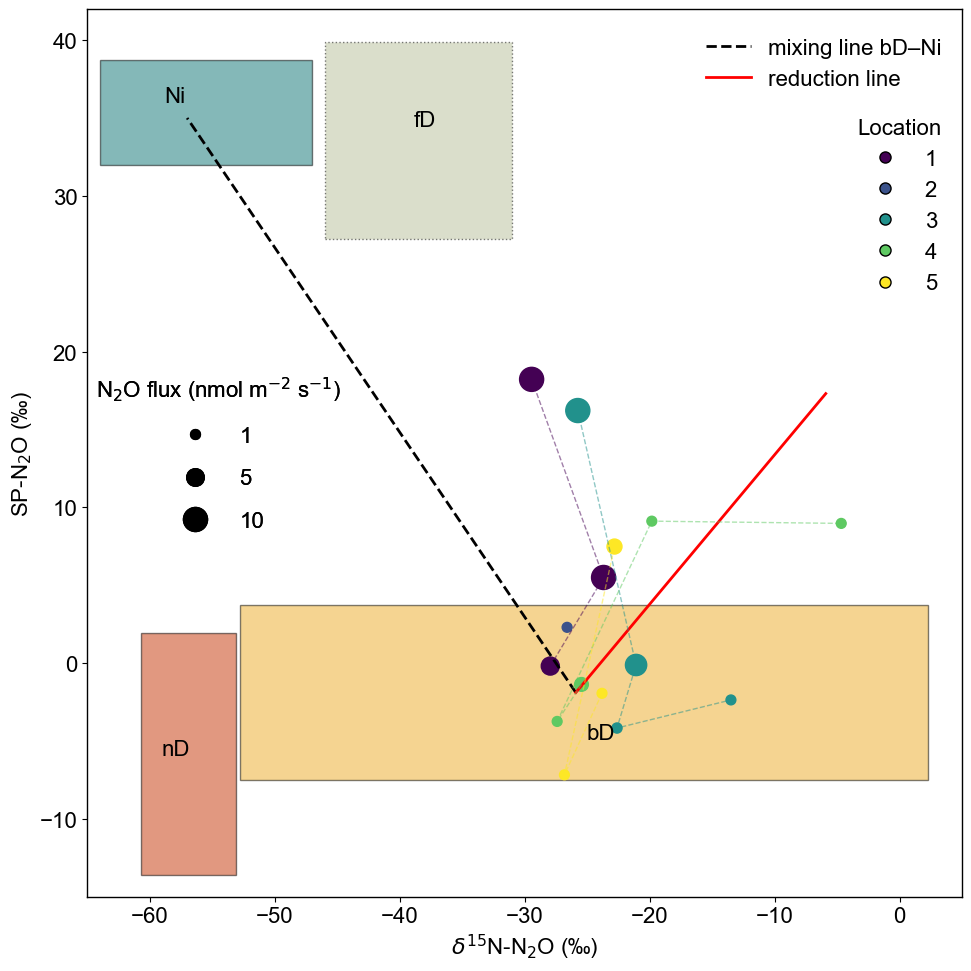

In [ ]:
def plot_d15N_SP(ax):
    # Unpack box data
    d15N_boxes = process_boxes['d15N']
    colors = {'Ni': '#0A7373', 'bD': '#EDAA25', 'fD': '#B7BF99', 'nD': '#C43302'}

    # Draw shaded boxes
    for label, box in d15N_boxes.items():
        rect = plt.Rectangle((box['xmin'], box['ymin']),
                             box['xmax'] - box['xmin'],
                             box['ymax'] - box['ymin'],
                             facecolor=colors[label], alpha=0.5,
                             linestyle='dotted' if label == 'fD' else 'solid',
                             edgecolor='black')
        ax.add_patch(rect)
        # Add the box labels
        offset = label_offsets['SP_d15N'].get(label, {'x': 0, 'y': 0})
        ax.text(box['x'] + offset['x'], box['y'] + offset['y'],
                label, ha='center')

    # Reduction and mixing lines
    x_bD, y_bD = d15N_boxes['bD']['x'], d15N_boxes['bD']['y']
    x_Ni, y_Ni = d15N_boxes['Ni']['x'], d15N_boxes['Ni']['y']
    x_fD, y_fD = d15N_boxes['fD']['x'], d15N_boxes['fD']['y']
    x_end = x_bD + 20
    y_end = y_bD + 20 * slopes['SP_d15N']['reduction']

    ax.plot([x_bD, x_Ni], [y_bD, y_Ni], 'k--', lw=2, label="mixing line bD–Ni")
#    ax.plot([x_bD, x_fD], [y_bD, y_fD], 'k--', lw=2, label="mixing line bD–fD")
    ax.plot([x_bD, x_end], [y_bD, y_end], 'r-', lw=2, label="reduction line")

    # Rescale flux to point size
    min_size, max_size = 50, 300
    flux = iso_data['flux_nmol']
    sizes = np.interp(flux, (1, 10), (min_size, max_size))

    # Scatter
    scatter = ax.scatter(iso_data['d15N'], iso_data['SP'],
                         c=iso_data['chamber'].cat.codes,
                         s=sizes, cmap='viridis', edgecolor='face')

    # Annotate date
    # for _, row in iso_data.iterrows():
    #     ax.annotate(row['date'].strftime('%d').lstrip("0"),
    #                 (row['d15N'], row['SP']),
    #                 xytext=(8, -8), textcoords='offset points', fontsize=8)

    # Chamber lines
    chambers = iso_data['chamber'].cat.categories
    colors_chamber = plt.cm.viridis(np.linspace(0, 1, len(chambers)))
    for i, chamber in enumerate(chambers):
        subset = iso_data[iso_data['chamber'] == chamber]
        ax.plot(subset['d15N'], subset['SP'], linestyle='dashed',
                linewidth=1, alpha=0.5, color=colors_chamber[i])

    # --- Reference lines legend
    reference_lines = [
        Line2D([0], [0], color='black', linestyle='--', linewidth=2, label='mixing line bD–Ni'),
    #    Line2D([0], [0], color='black', linestyle='--', linewidth=2, label='mixing line bD–fD'),
        Line2D([0], [0], color='red', linestyle='-', linewidth=2, label='reduction line')
    ]

    legend1 = ax.legend(handles=reference_lines,
                        loc="upper right",
                        bbox_to_anchor=(1, 0.99),
                        frameon=False)  # no title
    ax.add_artist(legend1)

    # --- Color legend
    chambers = iso_data['chamber'].cat.categories
    colors_chamber = plt.cm.viridis(np.linspace(0, 1, len(chambers)))
    legend_colors = [Line2D([0], [0], marker='o', color='none',
                            label=ch,
                            markerfacecolor=colors_chamber[i],
                            markersize=8)
                    for i, ch in enumerate(chambers)]

    legend2 = ax.legend(handles=legend_colors,
                        title="Location", 
                        loc="upper right",
                        bbox_to_anchor=(1, 0.9),
                        frameon=False)
    ax.add_artist(legend2)

    # --- Size legend
    flux_vals = [1, 5, 10]
    sizes_legend = np.interp(flux_vals, (1, 10), (min_size, max_size))
    legend_sizes = [
        Line2D([0], [0], marker='o', linestyle='None',
            markerfacecolor='black', markeredgecolor='black',
            markersize=np.sqrt(s), label=f"{f}")
        for f, s in zip(flux_vals, sizes_legend)
    ]

    legend3 = ax.legend(
        handles=legend_sizes,
        title="N$_{2}$O flux (nmol m$^{-2}$ s$^{-1}$)",
        loc="center left",
        bbox_to_anchor=(0, 0.5),
        frameon=False,
        handletextpad=1,     # space between symbol and label
        borderaxespad=0,     # padding between the legend and the axes (plot) border
        labelspacing=1       # vertical spacing
    )
    ax.add_artist(legend3)

    # Axis formatting
    ax.set_xlabel(r'$\delta^{15}$N-N$_2$O (‰)')
    ax.set_ylabel(r'SP-N$_2$O (‰)')
    ax.set_xlim(-65, 5)
    ax.set_ylim(-15, 42)
    ax.grid(False)
    ax.set_facecolor('white')
    ax.spines[:].set_linewidth(1)
    ax.tick_params(axis='both', which='major')
    return ax

# Plot
fig, ax = plt.subplots(figsize=(10, 10))  # Create one axis
plot_d15N_SP(ax)                          # Draw your plot on it
plt.tight_layout()
plt.savefig('../figures/N2O_dual_isotope_plot_d15N-SP.png', dpi=300)
plt.show()

## FRAME

### AGGREGATES

#### single chambers - all pathways

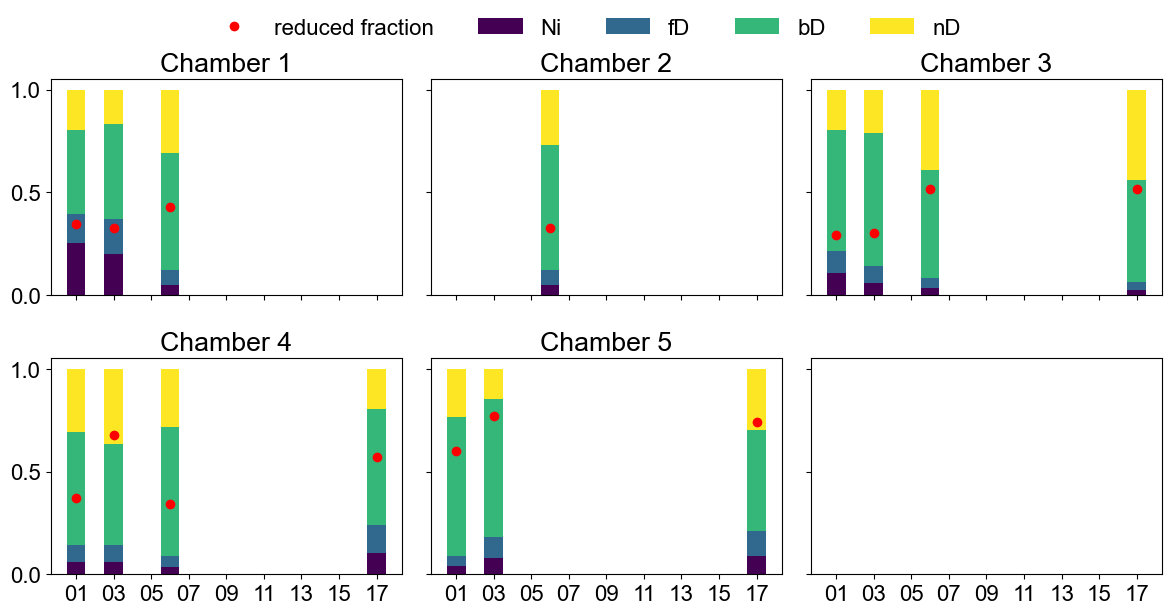

In [ ]:
df = df_summary
# Group by 'chamber' and loop through each group
chambers = sorted(df['chamber'].unique())
# Define colormap
colors = plt.cm.viridis(np.linspace(0, 1, 4))  # 4 because there are 4 source processes
# Define bar width
bar_width = 1

# Set the number of columns and calculate rows
n_columns = 3
n_chambers = len(chambers)
n_rows = (n_chambers + n_columns - 1) // n_columns  # Calculate rows needed

# Create subplots with shared x-axis
fig, axes = plt.subplots(n_rows, n_columns, figsize=(4*n_columns, 3*n_rows), sharex=True, sharey=True)
axes = axes.flatten()  # Flatten axes for easy indexing

for i in range(n_chambers):
    chamber = chambers[i]
    subset = df[df['chamber'] == chamber]
    dates = subset['date']

    # Set bottom to track cumulative sum for stacking
    bottom = np.zeros(len(subset))
    
    # Create the stacked bar plot with consistent bar width
    axes[i].bar(dates, subset['mean_Ni'], bottom=bottom, color=colors[0], width=bar_width)
    bottom += subset['mean_Ni']  # Update the bottom for the next process

    axes[i].bar(dates, subset['mean_fD'], bottom=bottom, color=colors[1], width=bar_width)
    bottom += subset['mean_fD']  # Update the bottom for the next process

    axes[i].bar(dates, subset['mean_bD'], bottom=bottom, color=colors[2], width=bar_width)
    bottom += subset['mean_bD']  # Update the bottom for the next process

    axes[i].bar(dates, subset['mean_nD'], bottom=bottom, color=colors[3], width=bar_width)

    # Plot also N2O ureduced fraction
    axes[i].plot(dates, subset['reduced_fraction'], 'o', color='red', label='unreduced fraction') 

    # Add title for each subplot
    axes[i].set_title(f'Chamber {chamber}')

    # Set the date format for x-axis
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%d'))  # Show only the day of the month
    axes[i].xaxis.set_major_locator(mdates.AutoDateLocator())  # Automatically space the dates

# Turn off unused axes (if any)
#for j in range(n_chambers, len(axes)):
#    fig.delaxes(axes[j])

# Add shared legend (only once), using labels from the last subplot
fig.legend(['reduced fraction', 'Ni', 'fD', 'bD', 'nD'], loc='upper center', ncol=5, bbox_to_anchor=(0.5, 1.05), frameon=False)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

#### pooling chambers

Aggregate of all chambers

In [ ]:
# Aggregate the data by 'date' using the median for each column
cols = [col for col in df.columns if 'mean' in col or 'date' in col or 'flux_nmol' in col or 'reduced_fraction' in col]
df_agg = df_summary[cols].groupby('date').mean().reset_index()
std_df = df_summary[cols].groupby('date').std().reset_index()
df_agg['date'] = df_agg['date'].dt.strftime('%Y-%m-%d')
std_df['date'] = std_df['date'].dt.strftime('%Y-%m-%d')

##### all pathways

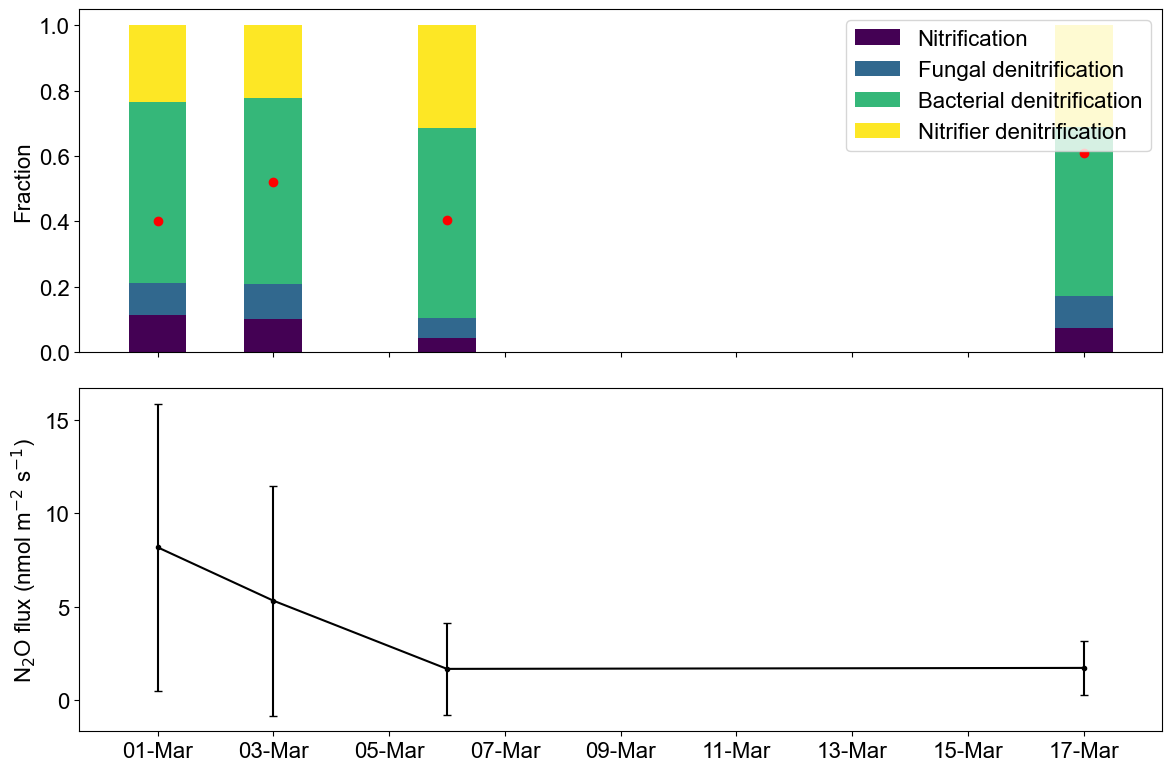

In [ ]:
# Define colormap
colors = plt.cm.viridis(np.linspace(0, 1, 4))  # 4 source processes
bar_width = 1

# Create subplots for a shared x-axis
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)  # Two subplots stacked vertically

# === Plot 1: Stacked bar chart for source contributions ===
ax1 = axes[0]
dates = pd.to_datetime(df_agg['date'])  # Ensure dates are in datetime format
# Initialize the bottom for stacking
bottom = np.zeros(len(df_agg))
# Add the stacked bars for each source process
ax1.bar(dates, df_agg['mean_Ni'], bottom=bottom, color=colors[0], label='Nitrification', width=bar_width)
bottom += df_agg['mean_Ni']  # Update the bottom for stacking
ax1.bar(dates, df_agg['mean_fD'], bottom=bottom, color=colors[1], label='Fungal denitrification', width=bar_width)
bottom += df_agg['mean_fD']
ax1.bar(dates, df_agg['mean_bD'], bottom=bottom, color=colors[2], label='Bacterial denitrification', width=bar_width)
bottom += df_agg['mean_bD']
ax1.bar(dates, df_agg['mean_nD'], bottom=bottom, color=colors[3], label='Nitrifier denitrification', width=bar_width)
# Customize the y-axis for the stacked bar chart
ax1.set_ylabel('Fraction')
# Add legend for the stacked bar chart
ax1.legend(loc='best')

# Plot also N2O ureduced fraction
ax1.plot(dates, df_agg['reduced_fraction'], 'o', color='red', label='reduced fraction') 

# === Plot 2: Line plot with error bars for N₂O flux ===
ax2 = axes[1]
flux = df_agg['flux_nmol']
flux_std = std_df['flux_nmol']
# Add the line plot with error bars
ax2.errorbar(dates, flux, yerr=flux_std, fmt='.-', capsize=3, color='black', label='N₂O flux')
# Customize the y-axis for the line plot
ax2.set_ylabel('N$_{2}$O flux (nmol m$^{-2}$ s$^{-1}$)')

# === Shared x-axis customization ===
for ax in axes:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))  # Display day-month
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())         # Automatically space dates

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the combined plot
plt.show()

##### pooling pathways

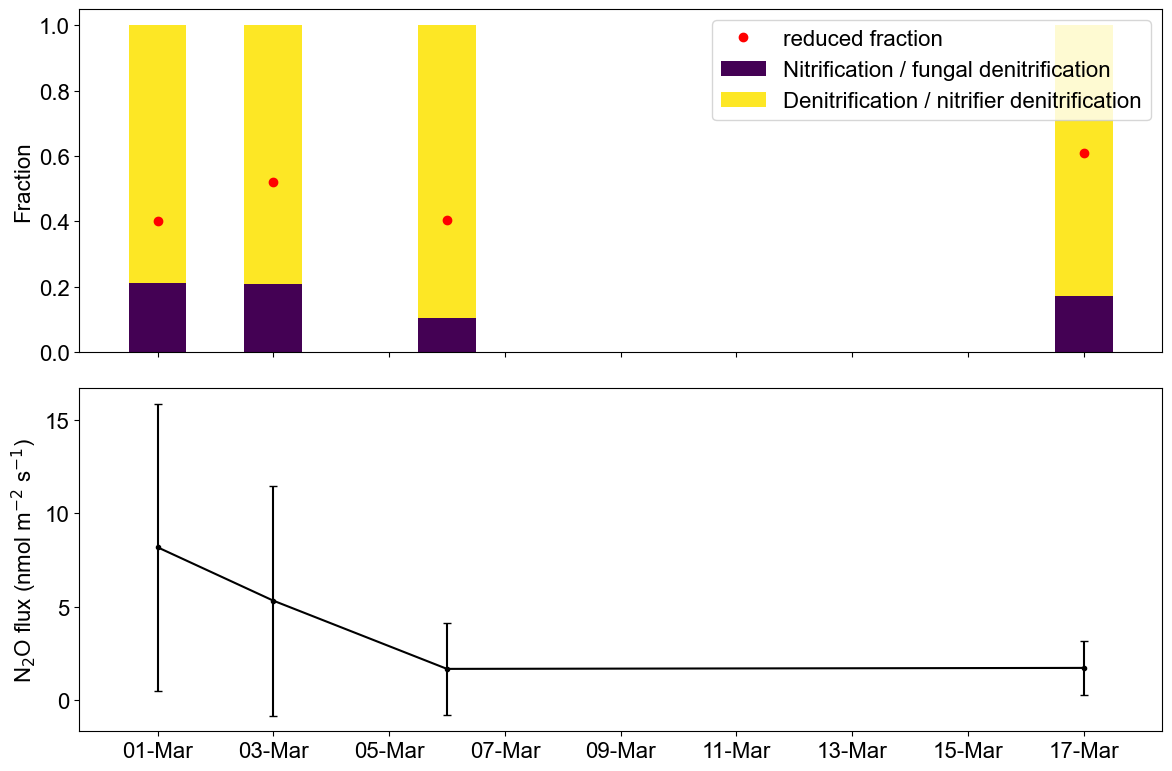

In [ ]:
# Define colormap
colors = plt.cm.viridis(np.linspace(0, 1, 2))  # 2 source processes
bar_width = 1

# Create subplots for a shared x-axis
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)  # Two subplots stacked vertically

# === Plot 1: Stacked bar chart for source contributions ===
ax1 = axes[0]
dates = pd.to_datetime(df_agg['date'])  # Ensure dates are in datetime format
# Initialize the bottom for stacking
bottom = np.zeros(len(df_agg))
# Add the stacked bars for each source process
ax1.bar(dates, df_agg['mean_Ni'] + df_agg['mean_fD'], bottom=bottom, color=colors[0], label='Nitrification / fungal denitrification', width=bar_width)
bottom += df_agg['mean_Ni'] + df_agg['mean_fD']  # Update the bottom for stacking
ax1.bar(dates, df_agg['mean_bD'] + df_agg['mean_nD'], bottom=bottom, color=colors[1], label='Denitrification / nitrifier denitrification', width=bar_width)
# Customize the y-axis for the stacked bar chart
ax1.set_ylabel('Fraction')

# Plot also N2O ureduced fraction
ax1.plot(dates, df_agg['reduced_fraction'], 'o', color='red', label='reduced fraction')
# Add legend for the stacked bar chart
ax1.legend(loc='best')



# === Plot 2: Line plot with error bars for N₂O flux ===
ax2 = axes[1]
flux = df_agg['flux_nmol']
flux_std = std_df['flux_nmol']
# Add the line plot with error bars
ax2.errorbar(dates, flux, yerr=flux_std, fmt='.-', capsize=3, color='black', label='N₂O flux')
# Customize the y-axis for the line plot
ax2.set_ylabel('N$_{2}$O flux (nmol m$^{-2}$ s$^{-1}$)')

# === Shared x-axis customization ===
for ax in axes:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))  # Display day-month
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())         # Automatically space dates

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the combined plot
plt.show()

#### Nitrification vs FN2O

Pooling together Ni and fD

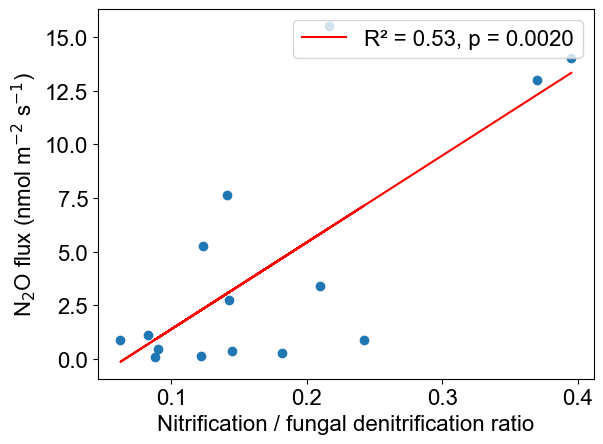

In [ ]:
df = df_summary
# Extracting the relevant data
y = df['flux_nmol'].values  # This is already a 1D array
X = (df['mean_Ni'] + df['mean_fD']).values  # Dependent variable remains 1D

# Performing linear regression
slope, intercept, r_value, p_value, std_err = linregress(X, y)

# Predicting values for the line of best fit
y_pred = slope * X + intercept

# Calculating the R-squared value
r2 = r2_score(y, y_pred)

# Calculating p-value using scipy.stats.linregress
slope, intercept, r_value, p_value, std_err = linregress(X, y)  # Pass X as 1D

# Plotting the scatter plot
plt.scatter(X, y)

# Plotting the regression line
plt.plot(X, y_pred, color='red', 
    label=f'R² = {r_value**2:.2f}, p = {p_value:.4f}')

plt.ylabel('N$_{2}$O flux (nmol m$^{-2}$ s$^{-1}$)')
plt.xlabel('Nitrification / fungal denitrification ratio')
plt.legend()
plt.show()

Only Ni

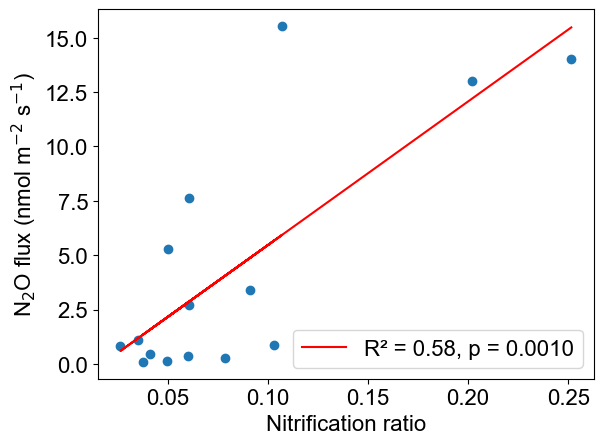

In [ ]:
df = df_summary
# Extracting the relevant data
y = df['flux_nmol'].values  # This is already a 1D array
X = df['mean_Ni'].values  # Dependent variable remains 1D

# Performing linear regression
slope, intercept, r_value, p_value, std_err = linregress(X, y)

# Predicting values for the line of best fit
y_pred = slope * X + intercept

# Calculating the R-squared value
r2 = r2_score(y, y_pred)

# Calculating p-value using scipy.stats.linregress
slope, intercept, r_value, p_value, std_err = linregress(X, y)  # Pass X as 1D

# Plotting the scatter plot
plt.scatter(X, y)

# Plotting the regression line
plt.plot(X, y_pred, color='red', 
    label=f'R² = {r_value**2:.2f}, p = {p_value:.4f}')

plt.ylabel('N$_{2}$O flux (nmol m$^{-2}$ s$^{-1}$)')
plt.xlabel('Nitrification ratio')
plt.legend()
plt.show()

#### Reduced n2o fraction vs FN2O

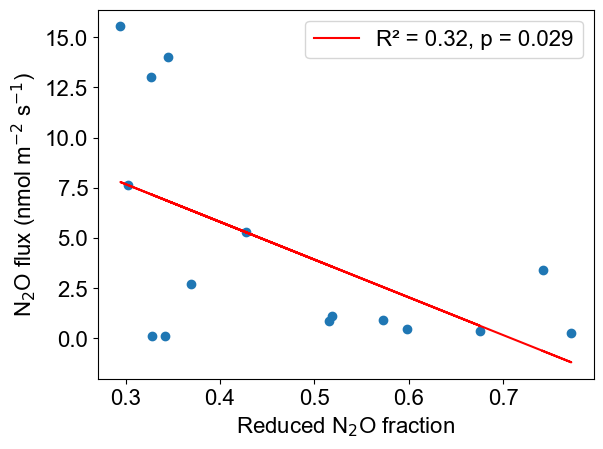

In [ ]:
df = df_summary
# Extracting the relevant data
y = df['flux_nmol'].values  # This is already a 1D array
X = df['reduced_fraction'].values  # Dependent variable remains 1D

# Performing linear regression
slope, intercept, r_value, p_value, std_err = linregress(X, y)

# Predicting values for the line of best fit
y_pred = slope * X + intercept

# Calculating the R-squared value
r2 = r2_score(y, y_pred)

# Calculating p-value using scipy.stats.linregress
slope, intercept, r_value, p_value, std_err = linregress(X, y)  # Pass X as 1D

# Plotting the scatter plot
plt.scatter(X, y)

# Plotting the regression line
plt.plot(X, y_pred, color='red', 
    label=f'R² = {r_value**2:.2f}, p = {p_value:.3f}')

plt.ylabel('N$_{2}$O flux (nmol m$^{-2}$ s$^{-1}$)')
plt.xlabel('Reduced N$_{2}$O fraction')
plt.legend()
plt.show()

### FULL OUTPUT

In [ ]:
# Melt the dataframe to have a 'variable' column for the two units
df_melted = df_full.melt(id_vars=['date'], value_vars=['Ni', 'bD', 'fD', 'nD'], 
                     var_name='Process', value_name='Value').sort_values(by="date")

df_melted['date'] = df_melted['date'].dt.strftime('%b-%d')

df_melted_pooled = df_full.melt(id_vars=['date'], value_vars=['denitrification', 'nitrification'], 
                     var_name='Process', value_name='Value').sort_values(by="date")

df_melted_pooled['date'] = df_melted_pooled['date'].dt.strftime('%b-%d')

In [ ]:
def plot_flux_with_reduced_fraction(ax):
    indat = df.copy()
    indat['date_str'] = indat['date'].dt.strftime('%b-%d')
    
    dodge = 0.05  # Adjust this value to control separation
    
    # --- primary axis: N2O flux ---
    sns.pointplot(
        x='date_str', y='flux_nmol', data=indat, ax=ax,
        color='black', capsize=0.05, errorbar='se',
        markers='o', linestyles='none', label='N$_{2}$O flux'
    )
    
    # Shift flux points to the left
    for line in ax.lines:
        xdata = line.get_xdata()
        line.set_xdata(xdata - dodge)
    for collection in ax.collections:
        offsets = collection.get_offsets()
        offsets[:, 0] -= dodge
        collection.set_offsets(offsets)
    
    ax.set_ylabel('N$_{2}$O flux (nmol m$^{-2}$ s$^{-1}$)', labelpad=0)
    ax.set_xlabel('')
    ax.tick_params(labelbottom=False, axis='both', which='major')
    
    # --- secondary axis: unreduced fraction r ---
    ax2 = ax.twinx()
    sns.pointplot(
        x='date_str', y='reduced_fraction', data=indat, ax=ax2,
        color='#6A0DAD', capsize=0.05, markers='o', errorbar='se',
        linestyles='none', label='Reduced N$_{2}$O fraction'
    )
    
    # Shift unreduced fraction points to the right
    for line in ax2.lines:
        xdata = line.get_xdata()
        line.set_xdata(xdata + dodge)
    for collection in ax2.collections:
        offsets = collection.get_offsets()
        offsets[:, 0] += dodge
        collection.set_offsets(offsets)
    
    ax2.set_ylabel('Reduced N$_{2}$O fraction')
    
    # Combine legends from both axes
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, frameon=False, loc='upper right')
    ax.legend_.remove()  # Remove the first legend to avoid duplication
    
    return ax, ax2

In [ ]:
def plot_pooled_fractions(ax):
    
    custom_palette = {"denitrification": "#EDAA25", "nitrification": "#0A7373"}

    indat = df.copy() # for the unreducted fraction
    indat['date'] = indat['date'].dt.strftime('%b-%d')

    sns.violinplot(
        x='date', y='Value', hue='Process', palette=custom_palette,
        data=df_melted_pooled, width=0.6, ax=ax, inner=None, alpha=0.5, cut=0)

    sns.pointplot(
        x='date', y='Value', hue='Process', data=df_melted_pooled,
        dodge=0.3, markers='D', linestyles='', estimator=np.mean, errorbar=None,
        markersize=10, ax=ax, palette=custom_palette, legend=None)
    
    handles, labels = ax.get_legend_handles_labels()
    custom_labels = ["Denitrification / nitrifier denitrification",
                     "Nitrification / fungal denitrification",
                     "Reduced N$_{2}$O fraction (r)"]
    ax.legend(handles, custom_labels,
            bbox_to_anchor=(0, 1.02), loc='lower left',
            borderaxespad=0., frameon=False)

    ax.set_xlabel('')
    ax.set_ylabel("Fraction")
    ax.set_xticks(range(len(indat['date'].unique())))
    ax.set_xticklabels(indat['date'].unique())
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
    ax.tick_params(axis='both', which='major')

    return ax

In [ ]:
def plot_all_fractions(ax):
    custom_palette = {
        'Ni': '#0A7373',   # Nitrification
        'bD': '#EDAA25',   # Bacterial denitrification
        'fD': '#B7BF99',   # Fungal denitrification
        'nD': '#C43302'    # Nitrifier denitrification
    }

    indat = df.copy()
    indat['date'] = indat['date'].dt.strftime('%b-%d')

    # Violin plot → keep legend here
    sns.violinplot(
        x='date', y='Value', hue='Process', data=df_melted,
        palette=custom_palette, width=0.6, ax=ax,
        inner=None, alpha=0.5, cut=0
    )

    # Point plot for process means → no legend
    sns.pointplot(
        x='date', y='Value', hue='Process', data=df_melted,
        dodge=0.45, markers='D', linestyles='', estimator=np.mean,
        errorbar=None, markersize=10, ax=ax,
        palette=custom_palette, legend=False
    )

    # Adjust legend from violinplot
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels,
              title='Process',
              bbox_to_anchor=(0, 1.02), loc='lower left',
              borderaxespad=0., frameon=False)

    # Formatting
    ax.set_xlabel('')
    ax.set_ylabel("Fraction")
    ax.set_xticks(range(len(indat['date'].unique())))
    ax.set_xticklabels(indat['date'].unique())
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
    ax.tick_params(axis='both', which='major')

    return ax

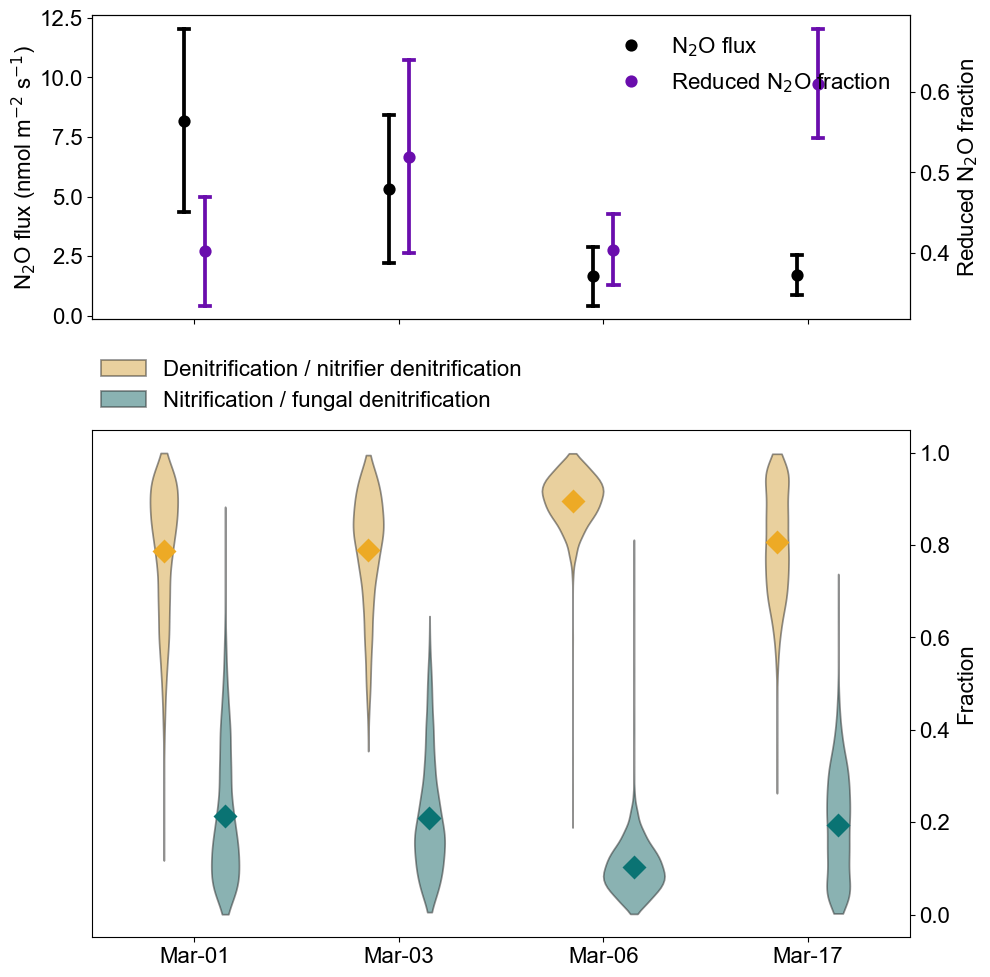

In [ ]:
# Create figure and define custom layout
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(nrows=2, ncols=1, height_ratios=[0.6, 1], figure=fig)

# Axes
ax_flux = fig.add_subplot(gs[0])      # Left column (spans both rows)
ax_frac = fig.add_subplot(gs[1])      # Top right

# Plot into each axis
ax_flux, ax_flux_r = plot_flux_with_reduced_fraction(ax_flux)
plot_pooled_fractions(ax_frac)

# Layout and save
plt.tight_layout()
plt.savefig("../figures/source_fractions_pooled_FRAME.png", dpi=300)
plt.show()

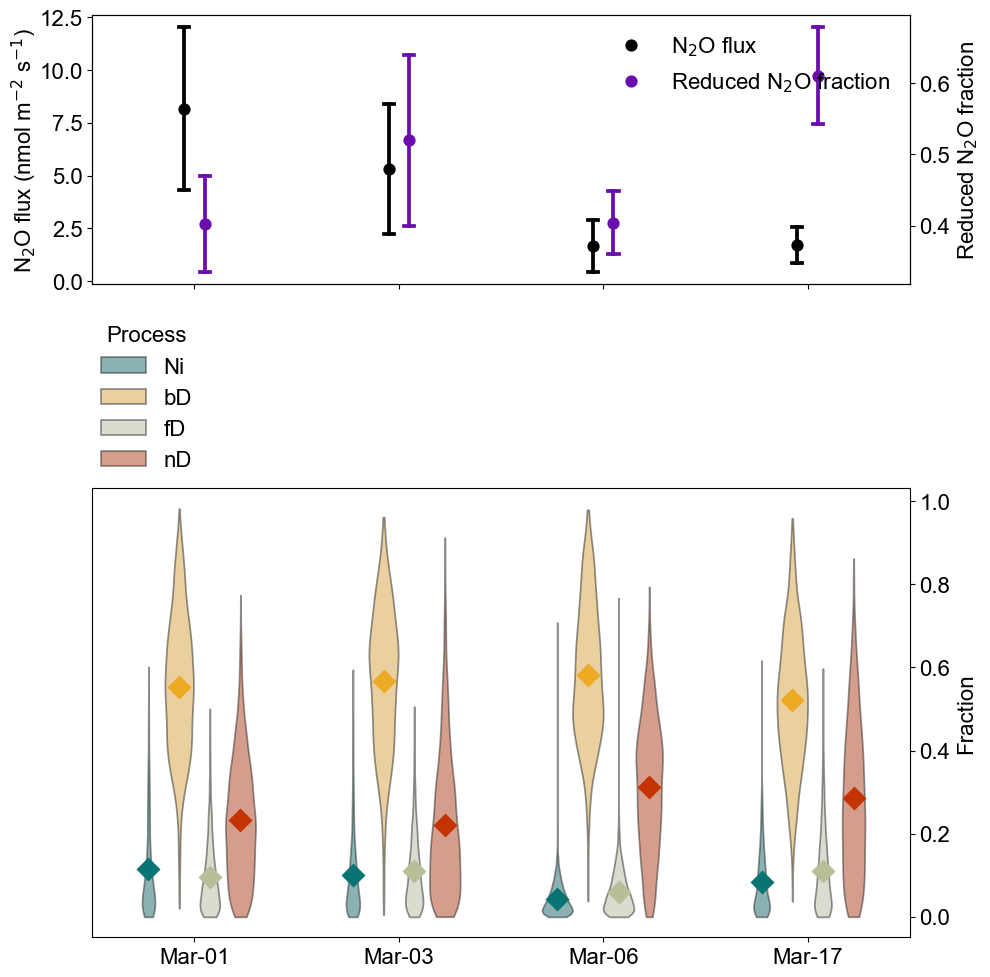

In [ ]:
# Create figure and define custom layout
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(nrows=2, ncols=1, height_ratios=[0.6, 1], figure=fig)

# Axes
ax_flux = fig.add_subplot(gs[0])      # Left column (spans both rows)
ax_frac = fig.add_subplot(gs[1])      # Top right

# Plot into each axis
ax_flux, ax_flux_r = plot_flux_with_reduced_fraction(ax_flux)
plot_all_fractions(ax_frac)

# Layout and save
plt.tight_layout()
plt.savefig("../figures/source_fractions_all_FRAME.png", dpi=300)
plt.show()

## FINAL FIG

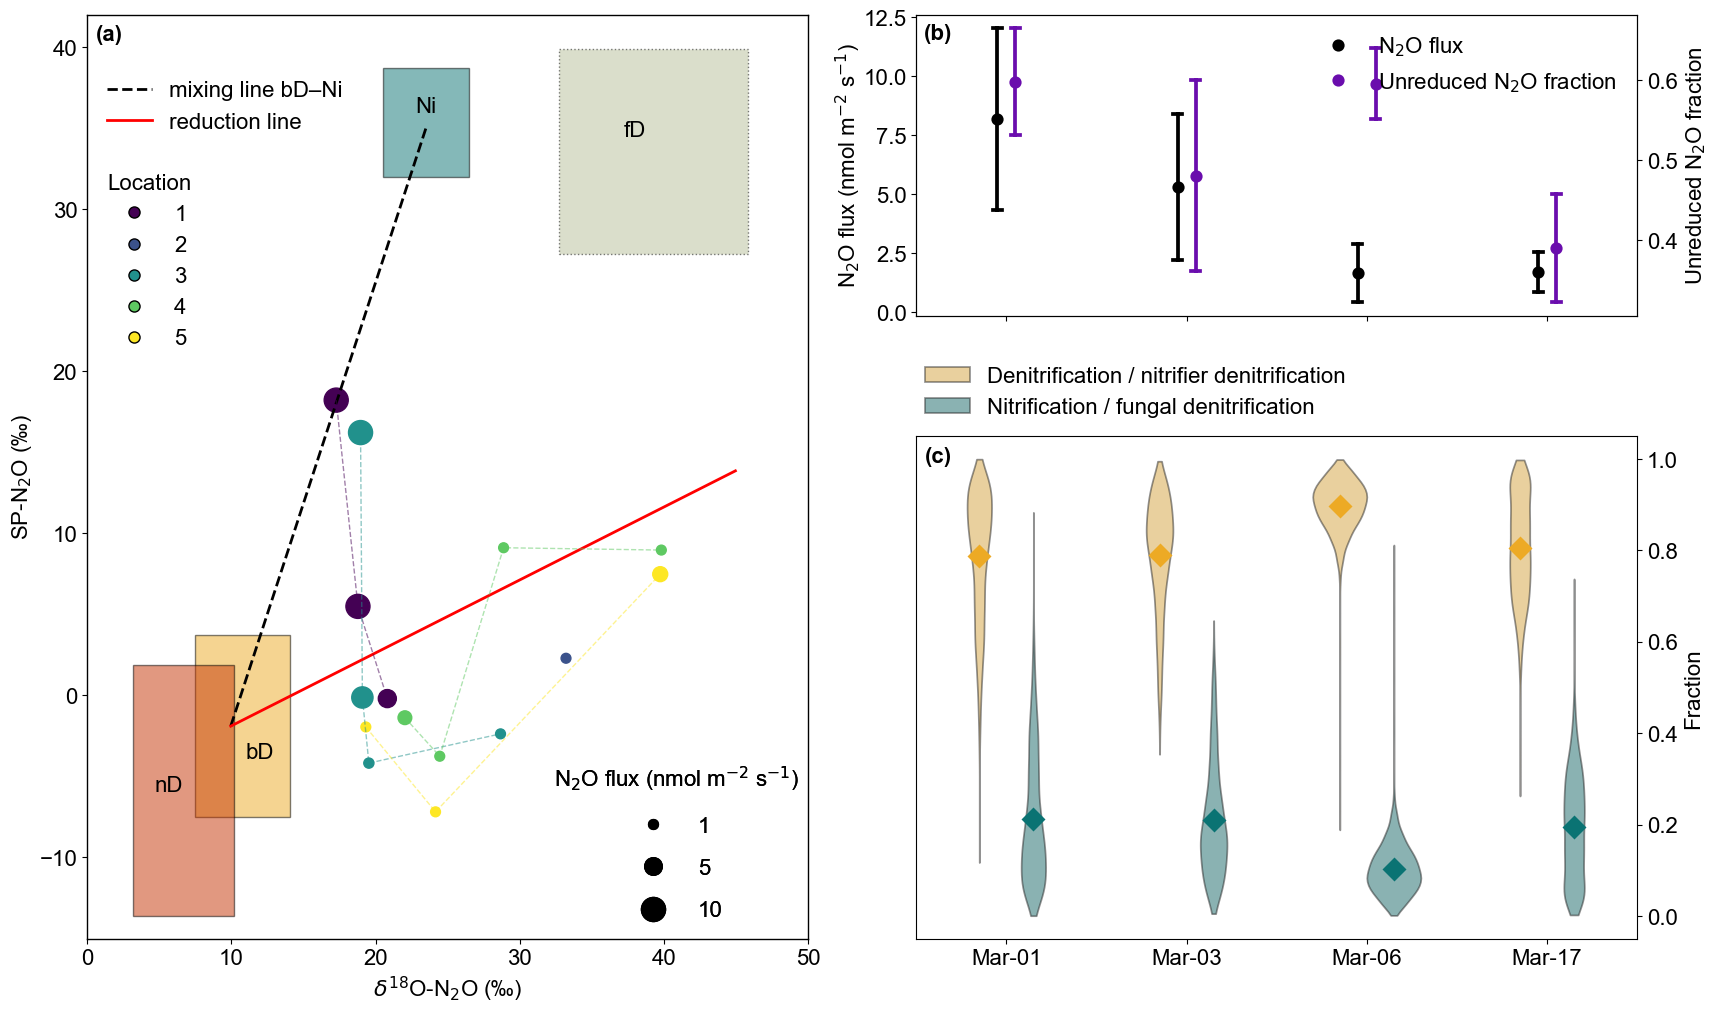

In [ ]:
# Set global font size
plt.rcParams.update({
    'font.size': 16,
    'font.family': 'Arial'  # or 'Times New Roman', 'DejaVu Sans', etc.
})
# Create figure and define custom layout
fig = plt.figure(figsize=(20, 12))
gs = GridSpec(nrows=2, ncols=2, width_ratios=[1, 1], height_ratios=[0.6, 1], figure=fig)

# Axes
ax_d18O = fig.add_subplot(gs[:, 0])      # Left column (spans both rows)
ax_flux = fig.add_subplot(gs[0, 1])      # Top right
ax_frac = fig.add_subplot(gs[1, 1])      # Bottom right

# Add subplot label
ax_d18O.text(0.05, 0.99, '(a)', transform=ax_d18O.transAxes, fontweight='bold', va='top', ha='right')
ax_flux.text(0.05, 0.97, '(b)', transform=ax_flux.transAxes, fontweight='bold', va='top', ha='right')
ax_frac.text(0.05, 0.98, '(c)', transform=ax_frac.transAxes, fontweight='bold', va='top', ha='right')

# Plot into each axis
plot_d18O_SP(ax_d18O)
ax_flux, ax_flux_r = plot_flux_with_reduced_fraction(ax_flux)
plot_pooled_fractions(ax_frac)

fig.subplots_adjust(wspace=0.15, hspace=0.3)  # Reduce horizontal & vertical spacing

# Plot and save
plt.savefig("../figures/combined_isotope_fig.png", dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()